In [2]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
from xskillscore import crps_ensemble

In [4]:
module_path = '/home/jupyter-ayoub'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer

In [ ]:
def fair_crps_ensemble(observations, forecasts, axis=0):

    # Convert inputs to numpy arrays if they're not already
    forecasts = np.asarray(forecasts)
    observations = np.asarray(observations)
    
    if axis != 1:
        forecasts = np.moveaxis(forecasts, axis, 1)
    
    # Get number of ensemble members
    m = forecasts.shape[1]
    
    # Calculate dxy: sum of absolute differences between forecasts and observations
    # Add a dimension to observations to allow broadcasting
    observations_expanded = np.expand_dims(observations, axis=1)
    dxy = np.sum(np.abs(forecasts - observations_expanded), axis=1)
    
    # Calculate dxx: sum of absolute differences between all pairs of ensemble members
    # Add dimensions to enable broadcasting for pairwise differences
    forecast_i = np.expand_dims(forecasts, axis=2)  # [batch, ens, 1, ...]
    forecast_j = np.expand_dims(forecasts, axis=1)  # [batch, 1, ens, ...]
    dxx = np.sum(np.abs(forecast_i - forecast_j), axis=(1, 2))
    
    # Calculate CRPS using the kernel approximation formula
    crps = dxy / m - dxx / (m * (m - 1) * 2)
    
    return crps

### Data preparation

In [5]:
#ssrd6
test_rfcs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_observation.nc")

In [6]:
test_rfcs=test_rfcs
obs=obs

In [ ]:
print(list(test_rfcs.data_vars))

In [7]:
target='ssrd6_obs'  
obs=obs[target]
test_rfcs=test_rfcs.drop_vars(['sd', 'mx2t6', 'mn2t6',  'q','ssr6','str6'])
#test_rfcs=test_rfcs.drop_vars(['t2m', 'z', 't', 'u10', 'v10', 'tcc', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'tp6', 'ssr6', 'str6', 'strd6'])
#test_rfcs=test_rfcs.drop_vars(['u10', 'v10', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'ssr6', 'str6']) #8
#[ 'sd', 'mx2t6', 'mn2t6', 'q', 'ssr6', 'str6']
#['sd', 'mx2t6', 'mn2t6', 'q', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6']

In [ ]:
print(list(test_rfcs.data_vars))

In [ ]:
print(obs.shape)

In [ ]:
#add orography as a variable
oro=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/oro.nc") 
dims={'time' : test_rfcs['time'],
       'number': test_rfcs['number'],
       'step': test_rfcs['step']}
xds_oro=oro.expand_dims(time=dims['time'], number=dims['number'],step=dims['step'])
dummy_oro=xr.Dataset(coords=dims)
final_oro=xds_oro.broadcast_like(dummy_oro)

In [ ]:
fcs_10=xr.merge([test_rfcs,final_oro])
dummy=xr.merge([test_rfcs,final_oro])

In [ ]:
#normalizing met oro.nc
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800),"ssr6":(0,3200000),"ssrd6":(-5200.0,18541902.0),"strd6":(2103856,9537712),"tp6":(-4,1),"ssr6":(-4220.0,15344816.0),"str6":(-4630656.0,1093968.0)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

def z_normalize(ds):
    for var in ds.data_vars:
        ds[var] = ds[var].copy()  # Ensure the variable is writable
        
        for t in range(len(ds["time"])):  # Loop over time dimension
            mean = ds[var].isel(time=t).mean()
            std = ds[var].isel(time=t).std()
            ds[var].loc[dict(time=ds["time"][t])] = (ds[var].isel(time=t) - mean) / std

    return ds



dummy_norm=minmax_normalize(dummy,min_max_values)
fcs_norm=dummy_norm

In [ ]:
%reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 32, 33, 18), n_heads=8,mlp_mult=4,projection_channels=64)

### Actual testing

In [ ]:
#this is where the last run is stored 
checkpoint_path = '/home/jupyter-ayoub/results/Transformerweights/ssrd6/epochs50predictors18CRPSKERNELSTEPlambda0.02k3.3.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

In [ ]:
#turn the normalized reforecasts into a tensor
fcs_norm_whole= fcs_norm.to_array(dim='variable')
print(fcs_norm_whole.sizes)
#print(fcs_norm_whole)

In [ ]:
print(fcs_norm_whole.shape)

In [ ]:
rearranged_10= fcs_norm_whole.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')

In [ ]:
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

In [ ]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')

In [ ]:
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')

In [ ]:
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

In [ ]:
import torch
postpro_10_whole = torch.empty((209,11,20,32,33,1))

# Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 2):
        # Get the end index for this chunk
        end = min(i + 2, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        #print(fcs_whole_tensor[i:end].shape)
        #print(postpro_10_whole[i:end].shape)
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])

In [ ]:
MBM_one=np.empty((209,11,20,32,33),dtype=float)
for i in range(20):
    mbm1=np.load(f"/home/jupyter-ayoub/ClassicalMBM/resultsClassicalMBM/{target}/MBM_{target}_{i}.npy")
    MBM_one[:,:,i,:,:]=mbm1.squeeze()

In [ ]:
ensemble_one = postpro_10_whole[...,0]
#print(fcs_whole_notnorm_tensor)
values_tar = fcs_whole_notnorm_tensor[:,:,:,:,:,5] #torch.Size([26, 11, 32, 33])
#print(values_tar)
scale_std, scale_mean= torch.std_mean(values_tar, dim=1, unbiased=True)
scaled_ensemble_one=(ensemble_one * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)).permute(1, 0, 2, 3, 4)
#print(scaled_ensemble_one)

In [ ]:
# Extract ensemble forecasts
ensemble_one = postpro_10_whole[...,0]

# Compute standard deviation & mean across ensemble dimension (dim=1)
scale_std, scale_mean = torch.std_mean(fcs_whole_notnorm_tensor[..., 15], dim=1, unbiased=True)

# Function to scale and clamp ensemble data
def scale_and_clamp(ensemble):
    scaled = ensemble * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)
    return torch.clamp(scaled, min=1e-6).permute(1, 0, 2, 3, 4)

# Apply scaling and clamping
scaled_ensemble_one = scale_and_clamp(ensemble_one)

In [ ]:
# Define coordinates with member first
coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}


# Define dimensions with member first
dims_forecast = ('member', 'time', 'step', 'latitude', 'longitude')

# Convert numpy arrays to xarray DataArray with the specified order
print("MBM_one shape:", MBM_one.shape)

MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)

# Compute mean and std across the member dimension
mean_one = full_ensemble_one.mean(dim='member')
std_one = full_ensemble_one.std(dim='member')

# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step', 'latitude', 'longitude')
raw_mean=raw_fcs.mean(dim='member')
raw_std=raw_fcs.std(dim='member')

In [ ]:
#ALL ENSEMBLES
Tformer_one=full_ensemble_one
MBM_one = MBM_one
Raw = raw_fcs['ssrd6']

In [ ]:
obs=obs.squeeze()

In [ ]:
output_dir = "/home/jupyter-ayoub/results/CRPS/ssrd6_18/ensembles"
os.makedirs(output_dir, exist_ok=True)
ensembles = {
    "Tformer_one": Tformer_one,
    "MBM_one": MBM_one,
    "Raw": Raw
}
observations = obs
print("obs shape")
print(observations.shape)
print("--------")
for name, ensemble in ensembles.items():
    print(ensemble.shape)
    
    # Compute fair ensemble CRPS
    f_crps = fair_crps_ensemble(observations, ensemble, axis=0)
    print(f_crps.shape)
    fair_crps = np.mean(f_crps)
    #print(fair_crps)
    
    np.save(f"{output_dir}/{name}_fair_crps.npy", fair_crps)
    

print("All CRPS computations complete!")

In [ ]:
output_dir = "/home/jupyter-ayoub/results/CRPS/ssrd6_18"
os.makedirs(output_dir, exist_ok=True)
ensembles = {
    "Tformer_one": Tformer_one,
    "MBM_one": MBM_one,
    "Raw": Raw
}
observations = obs
for name, ensemble in ensembles.items():
    print(ensemble.shape)
    
    # Compute fair ensemble CRPS
    f_crps = fair_crps_ensemble(observations, ensemble, axis=0)
    #print(f_crps.shape)
    fair_crps = np.mean(f_crps,axis=(0, 1))
    #print(fair_crps)
    
    np.save(f"{output_dir}/{name}_fair_crps.npy", fair_crps)
    

print("All CRPS computations complete!")

In [ ]:
import xskillscore as xs

output_dir = "/home/jupyter-ayoub/results/CRPS/ssrd6_18/leads"
os.makedirs(output_dir, exist_ok=True)

# Load observations (assuming you have them)
observations = obs
#print(Tformer_one)
# Dictionary of ensemble forecasts
ensembles = {
    "Tformer_one": Tformer_one,
    "MBM_one": MBM_one,
    "Raw": Raw
}

# Process each ensemble
for name, ensemble in ensembles.items():
    print(f"Processing {name}...")
    
    obs_broadcast = observations
    
    # Initialize arrays to store CRPS values
    # Assuming we compute CRPS for each leadtime
    n_leadtimes = ensemble.shape[2]
    #print(n_leadtimes)
    fair_crps = np.zeros(n_leadtimes)
    #fair_crps = np.zeros((32, 33))
    # Compute CRPS for each leadtime
    for lt in range(n_leadtimes):
        
        # Extract data for this leadtime
        ensemble_lt = ensemble[:, :, lt, :, :]  # (member, time, lat, lon)
        obs_lt = obs_broadcast[:, lt, :, :]  # (time, lat, lon)
        
        
        # Compute fair ensemble CRPS
        f_crps = fair_crps_ensemble(obs_lt, ensemble_lt, axis=0)
        print(f_crps.shape)
        fair_crps[lt] = np.mean(f_crps)
        #print(fair_crps[lt].shape)
    # Save results
    #np.save(f"{output_dir}/{name}_gaussian_crps.npy", gaussian_crps)
    np.save(f"{output_dir}/{name}_fair_crps.npy", fair_crps)
    

print("All CRPS computations complete!")

TESTING

In [ ]:
np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/leads/Tformer_one_fair_crps.npy")

In [8]:
CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/leads/Tformer_one_fair_crps.npy")
#CRPS_TF_1_G = np.load("/home/jupyter-ayoub/results/CRPS/Tformer_one_gaussian_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/leads/MBM_one_fair_crps.npy")
#CRPS_MBM_1_G = np.load("/home/jupyter-ayoub/results/CRPS/MBM_one_gaussian_crps.npy")
CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/leads/Raw_fair_crps.npy")
#CRPS_OG_G=np.load("/home/jupyter-ayoub/results/CRPS/Raw_gaussian_crps.npy")
#print(CRPS_OG,CRPS_MBM_1,CRPS_TF_1,)
print(CRPS_OG.shape)
meanOG=np.mean(CRPS_OG)
#meanOG_g=np.mean(CRPS_OG_G)
meanmbm_1=np.mean(CRPS_MBM_1)
#meanmbm_1_g=np.mean(CRPS_MBM_1_G)
meantf_1=np.mean(CRPS_TF_1)
#meantf_1_g=np.mean(CRPS_TF_1_G)
#print(meanOG,meanOG_g,meanmbm_1,meanmbm_1_g,meantf_1,meantf_1_g)
print(meanOG,meanmbm_1,meantf_1,)

(20,)
342434.3021368424 377086.03610573284 322911.314756839


In [ ]:
Leadtimes=obs.step.values
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 15))
plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF_1, color='cyan',linestyle=':', marker='d' ,alpha=0.5,label='Postprocessed,Transformer 1 pred')
plt.plot(Leadtimes, CRPS_MBM_1, color='brown',linestyle=':', marker='*',alpha=0.5, label='Postprocessed, Classical MBM 1 pred')

plt.axhline(y=meanOG, color='red',linestyle=':')
plt.axhline(y=meantf_1, color='cyan',linestyle=':')
plt.axhline(y=meanmbm_1, color='brown',linestyle=':')

# Set title and labels
plt.title('Ensemble CRPS per lead time (wind speed 100m)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [J/m$^2$]', fontsize=18)

# Set y-axis limits and x-axis ticks
plt.xlim(0,123)
plt.ylim(5000,1000000)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()

In [ ]:
print(CRPS_TF_1.shape)

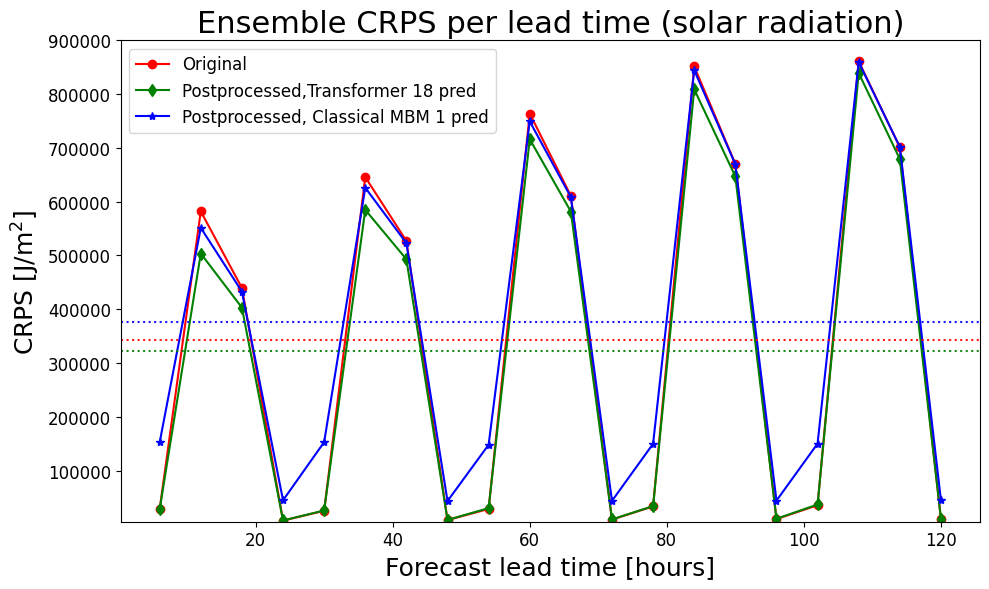

In [12]:
Leadtimes=obs.step.values
#matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 6))
plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF_1, color='green', marker='d' ,alpha=1,label='Postprocessed,Transformer 18 pred')
plt.plot(Leadtimes, CRPS_MBM_1, color='blue', marker='*',alpha=1, label='Postprocessed, Classical MBM 1 pred')

plt.axhline(y=meanOG, color='RED',linestyle=':',alpha=0.9)
plt.axhline(y=meantf_1, color='GREEN',linestyle=':',alpha=0.9)
plt.axhline(y=meanmbm_1, color='BLUE',linestyle=':',alpha=0.9)

# Set title and labels
plt.title('Ensemble CRPS per lead time (solar radiation)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [J/m$^2$]', fontsize=18)

# Set y-axis limits and x-axis ticks
#plt.xlim(0,123)
plt.ylim(5000,900000)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/CRPS_leadtime_all.png")
plt.show()

(20,) (20,) (20,)


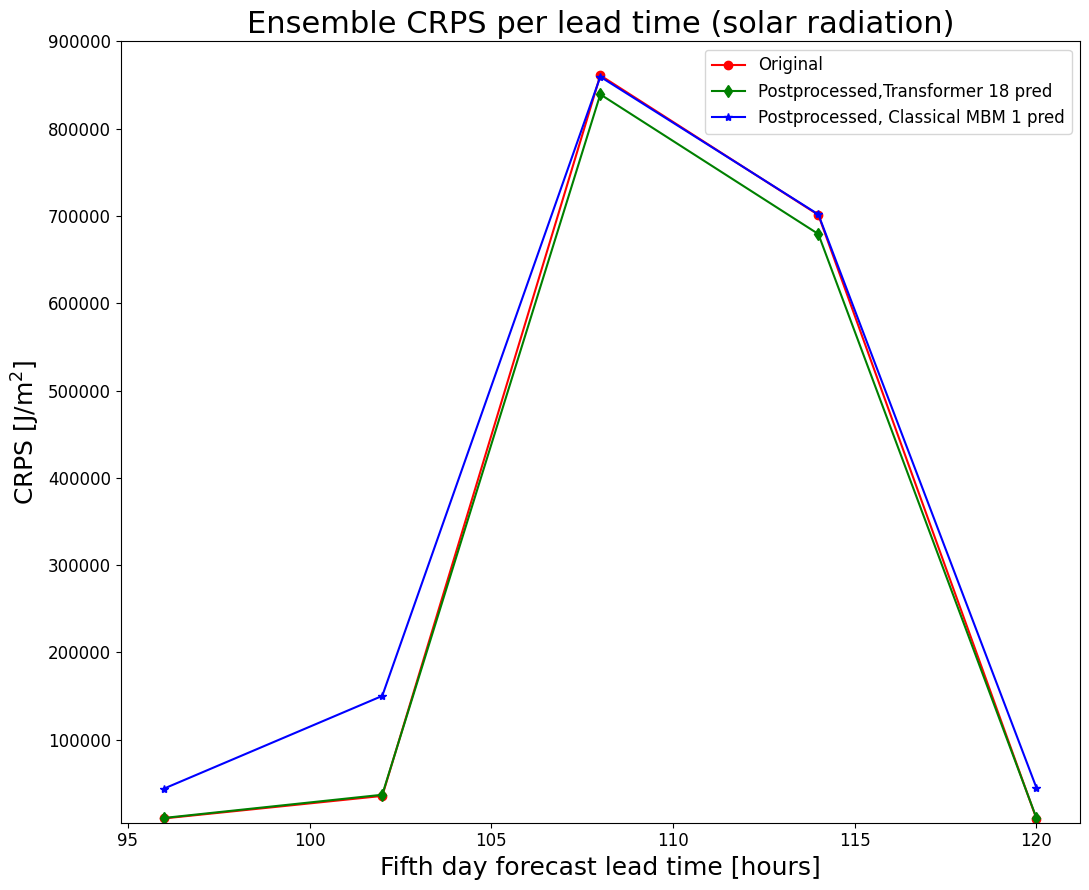

In [11]:
print(CRPS_OG.shape,CRPS_MBM_1.shape,CRPS_TF_1.shape)

Leadtimes=obs.step.values[-5:]
#matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(11, 9))
plt.plot(Leadtimes, CRPS_OG[-5:], color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF_1[-5:], color='green', marker='d' ,alpha=1,label='Postprocessed,Transformer 18 pred')
plt.plot(Leadtimes, CRPS_MBM_1[-5:], color='blue', marker='*',alpha=1, label='Postprocessed, Classical MBM 1 pred')


# Set title and labels
plt.title('Ensemble CRPS per lead time (solar radiation)', fontsize=22)
plt.xlabel('Fifth day forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [J/m$^2$]', fontsize=18)

# Set y-axis limits and x-axis ticks
#plt.xlim(0,123)
plt.ylim(5000,900000)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/CRPS_leadtime_lastday.png")
plt.show()

In [ ]:
print(CRPS_TF_1.shape)

In [ ]:
#Example of an ensemble
np.random.seed(156)  # For reproducibility #156
random_time = np.random.randint(0, Tformer_one.sizes["time"])
random_lat = np.random.randint(0, Tformer_one.sizes["latitude"])
random_lon = np.random.randint(0, Tformer_one.sizes["longitude"])
    
# Extract data for all 11 ensemble members at the chosen location
TF = Tformer_one[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
MBM = MBM_one[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
OBS = obs[random_time, :, random_lat, random_lon] 
RAW = Raw[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
# Plot all ensemble members as a function of step
plt.figure(figsize=(14, 9))
for member in range(11):
    plt.plot(obs.step.values,MBM[member, :] ,color='black',alpha=0.3, linewidth=0.5)
    plt.plot(obs.step.values, TF[member, :],color='blue',alpha=0.3, linewidth=0.5)
plt.plot(obs.step.values,np.mean(MBM,axis=0) ,color='black',alpha=0.8,linewidth=0.8,label="Postprocessed, Classical MBM")
plt.plot(obs.step.values, np.mean(TF,axis=0),color='blue',alpha=0.8,linewidth=0.8,label="Postprocessed, Transformer")
plt.plot(obs.step.values, np.mean(RAW,axis=0), color='green',linewidth=1.2,marker='o', markersize=5,alpha=1,label="Raw Forecasts")


# Formatting the plot
plt.xticks([ 24, 48, 72, 96, 120], [ 1, 2, 3, 4, 5])
plt.xlabel("Timestep, [days] ")
plt.ylabel("solar radiation, [J/m$^2$]")
plt.title("Ensemble forecast of solar radiation, randomly selected day",fontsize="18")
plt.legend(loc="upper right", fontsize=12, ncol=2)
plt.grid(True)
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/all_ensembles.png")
plt.show()

In [ ]:
print("Eerste stap:", obs.step.values[3])

In [ ]:
#Example of an ensemble
np.random.seed(156)  # For reproducibility #156
random_time = np.random.randint(0, Tformer_one.sizes["time"])
random_lat = np.random.randint(0, Tformer_one.sizes["latitude"])
random_lon = np.random.randint(0, Tformer_one.sizes["longitude"])
#random_step = np.random.randint(2, obs.sizes["step"])
random_step = slice(-4, None)  # eerste 6 tijdstappen

# Extract data for all 11 ensemble members at the chosen location
TF = Tformer_one[:, random_time, random_step, random_lat, random_lon]  # Shape: (11, step)
MBM = MBM_one[:, random_time, random_step, random_lat, random_lon]  # Shape: (11, step)
OBS = obs[random_time, random_step, random_lat, random_lon] 
RAW = Raw[:, random_time, random_step, random_lat, random_lon]  # Shape: (11, step)
# Plot all ensemble members as a function of step
plt.figure(figsize=(14, 9))
x = obs.step.values[-4:]  # de eerste 6 tijdstappen

plt.plot(x, np.mean(MBM,axis=0), color='black',alpha=0.8,marker='o',linewidth=0.8,label="Postprocessed, Classical MBM")
plt.plot(x, np.mean(TF,axis=0), color='blue',alpha=0.8,marker='o',linewidth=0.8,label="Postprocessed, Transformer")
plt.plot(x, np.mean(RAW,axis=0), color='green',linewidth=1.2,marker='o', markersize=5,alpha=1,label="Raw Forecasts")
plt.plot(x, OBS, color='red', linewidth=1.2, marker='o', markersize=5,alpha=1,label="OBS Forecasts")

# Formatting the plot
plt.xlabel("5 day , [hours] ")
plt.ylabel("solar radiation, [J/m$^2$]")
plt.title("Ensemble forecast of solar radiation, randomly selected day",fontsize="18")
plt.legend(loc="upper right", fontsize=12, ncol=2)
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load CRPS arrays
CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/leads/Tformer_one_fair_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/leads/MBM_one_fair_crps.npy")
CRPS_OG = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/leads/Raw_fair_crps.npy")

# Check shape
print("TF shape:", CRPS_TF_1.shape)
print("MBM shape:", CRPS_MBM_1.shape)
print("OG shape:", CRPS_OG.shape)

# Zorg dat we shape hebben van (samples, leadtimes) → dan nemen we mean over samples
def get_leadtime_mean(crps_array):
    if crps_array.ndim == 2:
        # (samples, leadtimes) of (leadtimes, samples)
        if crps_array.shape[0] < crps_array.shape[1]:
            return crps_array.mean(axis=0)  # (samples, leadtimes)
        else:
            return crps_array.mean(axis=1)  # (leadtimes, samples)
    elif crps_array.ndim == 3:
        return crps_array.mean(axis=(1,2))  # (leadtimes, lat, lon)
    elif crps_array.ndim == 1:
        return crps_array  # enkel 1 lead time, al geaggregeerd
    else:
        raise ValueError("Onverwachte CRPS shape.")

mean_crps_tf = get_leadtime_mean(CRPS_TF_1)
mean_crps_mbm = get_leadtime_mean(CRPS_MBM_1)
mean_crps_og = get_leadtime_mean(CRPS_OG)

# Plot alle leadtimes
lead_times = obs.step.values
plt.figure(figsize=(10, 6))
plt.plot(lead_times, mean_crps_og, label='Raw Forecast (OG)')
plt.plot(lead_times, mean_crps_mbm, label='MBM')
plt.plot(lead_times, mean_crps_tf, label='Transformer')
plt.xlabel("Lead time, days")
plt.ylabel("Mean CRPS, [J/m$^2$]")
plt.title("Mean CRPS per Lead Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

lons = obs.longitude.values  # of .lon
lats = obs.latitude.values

CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/Tformer_one_fair_crps.npy")
#CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/MBM_one_fair_crps.npy")
CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/Raw_fair_crps.npy")
# Data voorbereiden
diff = CRPS_OG - CRPS_TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
#levels = np.linspace(-10000, 56000, 18)
levels = np.array([-10000, 0, 10000,20000, 30000,40000, 50000,60000, 70000,80000, 90000])
cf = ax.contourf(lon2d, lat2d, diff,
                 transform=ccrs.PlateCarree(),levels=levels,cmap='Oranges')

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'CRPS [J/m$^2$]', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.tight_layout()
plt.figtext(0.5, -0.08, r"(a) Raw - Transformer", fontsize=12, ha='center')
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/crps_map_raw-transformer.png", bbox_inches='tight')
plt.show()

In [ ]:
CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/Tformer_one_fair_crps.npy")
print(CRPS_TF_1)
print("next")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/MBM_one_fair_crps.npy")
print(CRPS_MBM_1)

In [1]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = obs.longitude.values  # of .lon
lats = obs.latitude.values

CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/Tformer_one_fair_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/MBM_one_fair_crps.npy")
#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  CRPS_MBM_1 - CRPS_TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
#levels = np.linspace(0, 0.27, 10)
norm = TwoSlopeNorm(vmin=-0.15, vcenter=0.0, vmax=0.075)
levels = np.array([-10000, 0, 10000, 20000, 30000, 40000, 50000, 60000, 
                   70000, 80000, 90000, 100000])
cf = ax.contourf(lon2d, lat2d, diff,levels=levels, cmap='Oranges',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'CRPS [J/m$^2$]', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.tight_layout()
plt.figtext(0.5, -0.08, r"(b) Classical MBM - Transformer", fontsize=12, ha='center')
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/crps_map_mbm-transformer.png", bbox_inches='tight')
plt.show()

NameError: name 'obs' is not defined

In [ ]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = obs.longitude.values  # of .lon
lats = obs.latitude.values

CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/Tformer_one_fair_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/MBM_one_fair_crps.npy")
#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/ssrd6_18/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  CRPS_OG - CRPS_MBM_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
#levels = np.linspace(0, 0.27, 10)
norm = TwoSlopeNorm(vmin=-0.15, vcenter=0.0, vmax=0.075)
levels = np.array([0, 10000, 20000, 30000, 40000, 50000, 60000, 
                   70000, 80000, 90000, 100000])
cf = ax.contourf(lon2d, lat2d, diff, cmap='Blues',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'CRPS [J/m$^2$]', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.figtext(0.5, -0.08, r"(c) RAW - Classical MBM", fontsize=12, ha='center')

plt.tight_layout()
plt.show()